In [1]:
# Required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import spacy
from textblob import TextBlob
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Text(0, 0.5, '')

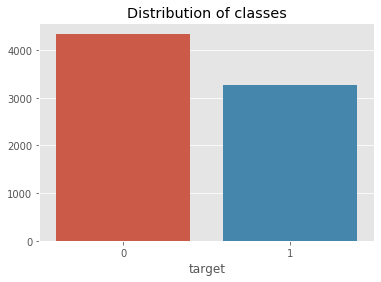

In [5]:
sns.countplot(x= 'target', data= df_train)
plt.title('Distribution of classes')
plt.ylabel('')

In [6]:
# Combine both train and test
total = pd.concat([df_train, df_test], axis= 0, ignore_index= True)
total.tail()

,id,keyword,location,text,target
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


Text(0.5, 1.0, 'Missing values in data set')

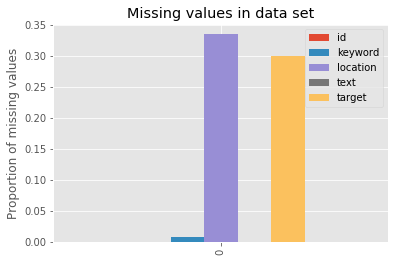

In [7]:
df_missing = pd.DataFrame((total.isnull().sum().values/ total.shape[0]).reshape(1,5),\
                          columns= total.columns)
df_missing.plot(kind= 'bar')
plt.ylabel('Proportion of missing values')
plt.title('Missing values in data set')

In [8]:
total.drop(['location', 'keyword'], axis= 1, inplace= True)

Text(0.5, 1.0, 'Distribution of Characters in both classes')

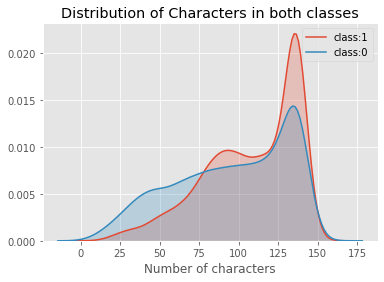

In [9]:
# Calculating number of charaters in each tweet

total['num_char'] = total['text'].apply(lambda x: len(x))
train = total.iloc[:len(df_train)]
fig, ax = plt.subplots()
sns.kdeplot(train[train['target'] == 1].num_char, shade= True, ax=ax)
sns.kdeplot(train[train['target'] == 0].num_char, shade= True, ax= ax)
plt.legend(['class:1', 'class:0'])
plt.xlabel('Number of characters')
plt.title('Distribution of Characters in both classes')

In [10]:
# Word count 
nlp = spacy.load('en_core_web_sm')
total['word_count'] = total['text'].apply(lambda x: len(nlp(x)))
train = total.iloc[:len(df_train)]
# Average word lenth
def av_len(string):
    doc = nlp(string)
    li = [token.text for token in doc]
    li2 = [len(word) for word in li]
    return np.sum(li2)
total['av_wordlen'] = total['text'].apply(lambda x: av_len(x))

train = total.iloc[:len(df_train)]

Text(0.5, 1.0, 'Average word length distribution')

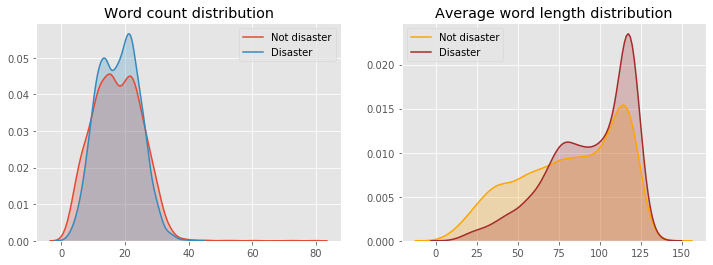

In [11]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 4))
sns.kdeplot(train[train['target'] == 0].word_count, shade= True, ax= ax[0])
sns.kdeplot(train[train['target'] == 1].word_count, shade= True, ax= ax[0])
ax[0].legend(['Not disaster', 'Disaster'])
ax[0].set_title('Word count distribution')

sns.kdeplot(train[train['target'] == 0].av_wordlen, shade= True, ax= ax[1], color= 'orange')
sns.kdeplot(train[train['target'] == 1].av_wordlen, shade= True, ax= ax[1], color= 'brown')
ax[1].legend(['Not disaster', 'Disaster'])
ax[1].set_title('Average word length distribution')

Text(0.5, 1.0, 'Number of Hashtags in each classes')

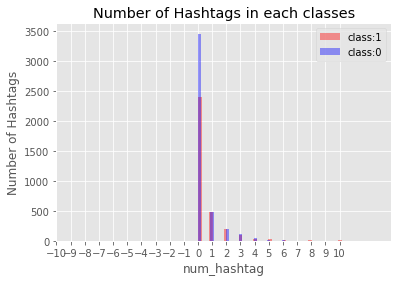

In [13]:
# Number of hashtags 
def hash_count(string):
    return len(re.findall('#', string))

total['num_hashtag'] = total['text'].apply(lambda x: hash_count(x))
train = total.iloc[:len(df_train)]

fig, ax = plt.subplots()
sns.distplot(train[train['target'] == 1].num_hashtag, ax=ax, kde=False, bins=50, color= 'red')
sns.distplot(train[train['target'] == 0].num_hashtag,  ax= ax, kde=False, bins= 50, color= 'blue')
ax.set(xticks= np.arange(-10, 11, 1))
plt.legend(['class:1', 'class:0'])
plt.ylabel('Number of Hashtags')
plt.title('Number of Hashtags in each classes')


In [14]:
# Not a very informative feature
total.drop(columns= ['num_hashtag'], inplace= True)

In [15]:
# Readability score( gunning fog score) # higher score ~ harder to read
total['gunning_score'] = total['text'].apply(lambda x: textstat.gunning_fog(x))
train = total.iloc[:len(df_train)]

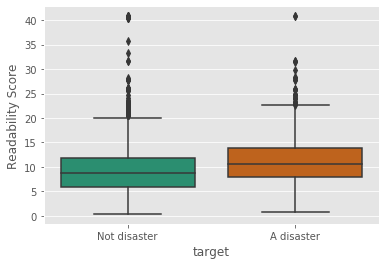

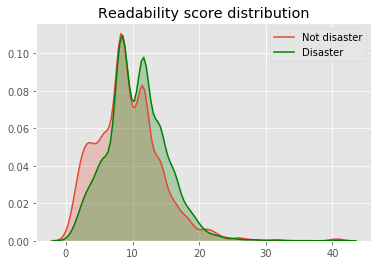

In [16]:
g = sns.boxplot(x= 'target', y= 'gunning_score', data= train, palette= sns.color_palette('Dark2'))
plt.setp(g, xticklabels= ['Not disaster', 'A disaster'])
plt.ylabel('Readability Score')
plt.show()

fig, ax = plt.subplots(nrows= 1, ncols= 1)
sns.kdeplot(train[train['target'] == 0].gunning_score, shade= True, ax= ax)
sns.kdeplot(train[train['target'] == 1].gunning_score, shade= True, ax=ax, color= 'green')
ax.legend(['Not disaster', 'Disaster'])
plt.title('Readability score distribution')
plt.show()

In [17]:
# Clean text vectors
# Three processes: Lemmetization, stop words, punctuations
stop_words = spacy.lang.en.stop_words.STOP_WORDS
def clean_text(string):
    doc = nlp(string)
    clean = [token.lemma_ for token in doc\
                  if token.lemma_.isalpha() and token.lemma_ not in stop_words]
    clean = set(clean)
    return ' '.join([correct for correct in clean])

total['clean_text'] = total['text'].apply(lambda x: clean_text(x))

In [18]:
total[['text', 'clean_text']].sample(10)

,text,clean_text
10818,ME: gun shot wounds 3 4 6 7 'rapidly lethal' w...,wound gun max kerricktrial rapidly shot minute...
1181,#computers #gadgets Two giant cranes holding a...,bridge crane slingnews giant gadget home compu...
3230,Providence Health &amp; Services: Emergency Se...,AK Emergency Department Job Supervisor Health ...
8124,BREAKING NEWS: Australia collapse to a hapless...,hapless Trent Australia NEWS collapse BREAKING...
3359,Gold Coast tram hit by fallen powerlines: UP t...,people fall af Coast evacuate Gold tram powerl...
3704,I didn`t want to hurt you but the fear drove m...,fear drive hurt want midnight
1509,Learning from the most destructive volcanic ev...,history later learn event year volcanic destru...
517,#WeLoveLA #NHLDucks Avalanche Defense: How The...,welovela match vs Defense Louis sportsroadhous...
968,Check out Vintage Longaberger Floral Fabric Sh...,Leather Fabric Floral Cross Brown Shoulder Lon...
2047,The Danger and Excitement of Underwater Cave D...,Diving Underwater Excitement Danger Cave


In [19]:
# Named entity recognition
def NER(df):
    for row in range(df.shape[0]):
        doc = nlp(df.loc[row, 'clean_text'])
        ner = [ent.label_ for ent in doc.ents]
        for ent in ner:
            if 'NER_{}'.format(ent) not in df.columns:
                df['NER_{}'.format(ent)] = np.zeros(df.shape[0])
                df.loc[row, 'NER_{}'.format(ent)] += 1
            else:
                df.loc[row, 'NER_{}'.format(ent)] += 1

NER(total)

total.filter(regex= '^NER').sum()

NER_DATE            646.0
NER_GPE            1726.0
NER_LOC             269.0
NER_ORG            3630.0
NER_ORDINAL          70.0
NER_PERSON         2872.0
NER_TIME            171.0
NER_PRODUCT         249.0
NER_NORP            656.0
NER_WORK_OF_ART      88.0
NER_FAC             202.0
NER_LAW              14.0
NER_QUANTITY          4.0
NER_CARDINAL        117.0
NER_EVENT            73.0
NER_LANGUAGE          9.0
NER_MONEY             4.0
NER_PERCENT           1.0
dtype: float64

Text(0.5, 1.0, 'Distribution of NE in each class')

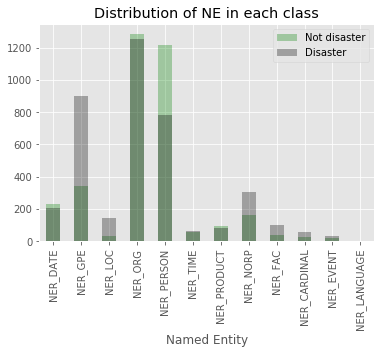

In [20]:
total.drop(columns= ['NER_WORK_OF_ART', 'NER_ORDINAL', 'NER_QUANTITY',\
                     'NER_QUANTITY', 'NER_LAW', 'NER_PERCENT', 'NER_MONEY'], inplace= True)
train = total.iloc[:len(df_train)]
# Plot NER
ner_1 = pd.DataFrame(train[train['target'] == 1].filter(regex= '^NER').sum(), columns= ['sum'],\
                     index= train[train['target'] == 1].filter(regex= '^NER').sum().index) 
ner_0 = pd.DataFrame(train[train['target'] == 0].filter(regex= '^NER').sum(), columns= ['sum'],\
                     index= train[train['target'] == 0].filter(regex= '^NER').sum().index)


fig, ax= plt.subplots()
ner_0.plot(kind= 'bar', ax= ax,color= 'green', alpha= 0.3)
ner_1.plot(kind= 'bar', ax= ax, color= 'black', alpha= 0.3)
ax.legend(['Not disaster', 'Disaster'])
ax.set_xlabel('Named Entity')
ax.set_title('Distribution of NE in each class')

In [21]:
# NER_GPE and NER_PERSON shows interesting behavior 
# All other distributions doesn't help much with the classification of class
to_drop = [col for col in total.filter(regex= '^NER').columns if col not in ['NER_GPE', 'NER_PERSON']]
total.drop(columns= to_drop, inplace= True)

In [22]:
total.head(2)

,id,text,target,num_char,word_count,av_wordlen,gunning_score,clean_text,NER_GPE,NER_PERSON
0,1,Our Deeds are the Reason of this #earthquake M...,1.0,69,14,57,5.2,May deed earthquake forgive reason allah,0.0,0.0
1,4,Forest fire near La Ronge Sask. Canada,1.0,38,8,32,2.8,near forest fire Canada La Ronge Sask,1.0,0.0


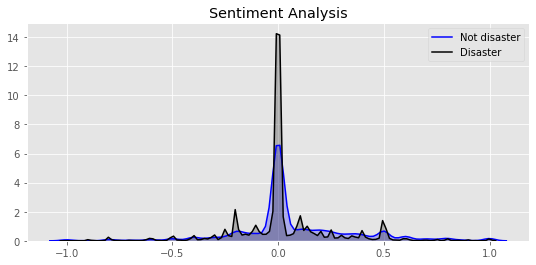

In [23]:
# Sentiment analysis
total['sentiment'] = total['text'].apply(lambda x: TextBlob(x).sentiment[0])
train = total.iloc[:len(df_train)]

fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize=(9,4))
sns.kdeplot(train[train['target'] == 0].sentiment, shade= True, ax= ax, color= 'blue')
sns.kdeplot(train[train['target'] == 1].sentiment, shade= True, ax= ax, color= 'black')
ax.legend(['Not disaster', 'Disaster'])
ax.set_title('Sentiment Analysis')
plt.show()

In [24]:
# Not very useful feature
total.drop(columns= ['sentiment'], inplace= True)

# Model Building

In [25]:
# We dont need 'clean_text' column anymore 
total.drop('clean_text', axis= 1, inplace= True)

In [26]:
# Prepare data
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# set random seed 
np.random.seed(34)
tf.random.set_seed(34)

# tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total['text'])
sequences = tokenizer.texts_to_sequences(total['text'])


word_index = tokenizer.word_index
print('There are %s tokens'% len(word_index))

text_data = pad_sequences(sequences)
text_input_train = text_data[:len(df_train)]
text_input_test = text_data[len(df_train):]


X_train = total[:len(df_train)].drop(['id', 'target'], axis= 1)
y_train = total[:len(df_train)]['target']
X_test = total[len(df_train):].drop(['id', 'target'], axis= 1) # null values in 'target' of test data

MAX_SEQUENCE_LENGTH = text_data.shape[1]

There are 29319 tokens


In [28]:
# get Glove vectors
embedding_index = {}
glove_path = 'glove.6B.300d.txt'
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype= 'float32')
        embedding_index[word] = coeff
        
print('There are %s vectors in Glove'% len(embedding_index))
        

There are 400000 vectors in Glove


In [29]:
EMBEDDING_DIM = 300 # 100d and 200d vectors are also present

In [32]:
# Create embedding matrix of our text_data
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM)) # 0th id is reserved for special characters

for word, idx in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        
        # words that are present in both text_data and glove data
        embedding_matrix[idx] = embedding_vector

In [33]:
print('Dimension of Embedding matrix: ', embedding_matrix.shape)

Dimension of Embedding matrix:  (29320, 300)


In [54]:
# things to do next 
# define embedding layer
# make 4 different model architechtures 
# ensure regularisation and normalization
# callbacks
# learning curves
# submission

In [106]:
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Concatenate,\
                                    Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, Input, Flatten
from tensorflow.keras.models import  Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 2)
model_save = ModelCheckpoint('best_model.hdf5', save_best_only= True)

embedding_layer = Embedding(input_dim= len(word_index) + 1,
                            input_length= MAX_SEQUENCE_LENGTH, 
                            output_dim= EMBEDDING_DIM,
                            weights= [embedding_matrix],
                            trainable= False
                           )


In [40]:
# Features extracted during exploratory data analysis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

meta_input_train = scaler.fit_transform(X_train.drop(columns= ['text']))

meta_input_test = scaler.transform(X_test.drop(columns= ['text']))

In [42]:
print(meta_input_train.shape, 'columns should be equal to ', meta_input_test.shape, 'columns')

(7613, 6) columns should be equal to  (3263, 6)


# 1) Simple LSTM

In [44]:
def create_lstm(spatial_dropout= 0.2, dropout= 0.15, recurrent_dropout= 0.15, learning_rate= 0.0001):
    
    # Input layers
    text_input = Input(shape= (MAX_SEQUENCE_LENGTH, ), name= 'Text_input')
    emb = embedding_layer(text_input)
    
    meta_input = Input(shape= (meta_input_train.shape[1], ), name= 'Numeric_input')
    # LSTM layer
    emb = SpatialDropout1D(spatial_dropout)(emb)
    text_output = Bidirectional(LSTM(128, dropout= dropout, recurrent_dropout= recurrent_dropout, name= "LSTM"))(emb)
    merge = Concatenate()([text_output, meta_input])
    merge = Dropout(dropout)(merge)
    
    # Output 
    preds = Dense(1, activation= 'sigmoid')(merge)
    
    # Compile
    model = Model([text_input, meta_input], preds)
    model.compile(optimizer= Adam(learning_rate= learning_rate), loss= 'binary_crossentropy', metrics= ['accuracy'])
    
    return model
    

In [74]:
# Learning curves
def plot_lr_curves(history, model_num):
    fig,ax = plt.subplots(nrows= 1, ncols= 2, figsize= (20,10))
    
    # accuracy Vs epochs
    ax[0].plot(history.history['val_accuracy'])
    ax[0].plot(history.history['accuracy'])
    ax[0].legend(['Validation', 'Training'], loc= 'upper left')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    
    # Loss Vs epochs
    ax[1].plot(history.history['val_loss'])
    ax[1].plot(history.history['loss'])
    ax[1].legend(['Validation', 'Training'], loc= 'upper left')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    
    fig.suptitle('Model Accuracy of model {}'.format(model_num), fontsize= 25)
    
    plt.show()

# 2) Complex LSTM

In [78]:
def create_lstm_complex(spatial_dropout= 0.2, dropout= 0.15,\
                recurrent_dropout= 0.15, learning_rate= 0.0001):
        # Input layers
    text_input = Input(shape= (MAX_SEQUENCE_LENGTH, ), name= 'Text_input')
    emb = embedding_layer(text_input)
    
    meta_input = Input(shape= (meta_input_train.shape[1], ), name= 'Numeric_input')
    # LSTM layer
    emb = SpatialDropout1D(spatial_dropout)(emb)
    text_output = Bidirectional(LSTM(128, dropout= dropout, recurrent_dropout= recurrent_dropout, name= "LSTM"))(emb)
    merge = Concatenate()([text_output, meta_input])
    merge = Dropout(dropout)(merge)
    x= Dense(128, activation= 'relu', name= 'Dense_1')(merge)
    x = Dropout(dropout)(x)
    x = Dense(64, activation= 'relu', name= 'Dense_2')(x)
    
    # Output 
    preds = Dense(1, activation= 'sigmoid')(x)
    
    # Compile
    model = Model([text_input, meta_input], preds)
    model.compile(optimizer= Adam(learning_rate= learning_rate), loss= 'binary_crossentropy', metrics= ['accuracy'])
    
    return model

# 3) LSTM + GRU

In [93]:
def create_lstm_gru( dropout= 0.15,\
                    recurrent_dropout= 0.15, learning_rate= 0.0001):
    
    # Input layers
    text_input = Input(shape= (MAX_SEQUENCE_LENGTH, ), name= 'Text_input')
    emb = embedding_layer(text_input)
    
    meta_input = Input(shape= (meta_input_train.shape[1], ), name= 'Numeric_input')
    
    #LSTM and gru
    x = Dense(EMBEDDING_DIM, activation= 'relu', name= 'Dense_1')(emb)
    x = Dropout(dropout)(x)
    x = LSTM(64, return_sequences= True, dropout= dropout,recurrent_dropout= recurrent_dropout, name= "LSTM")(x)
    x = GRU(64, return_sequences= False, dropout= dropout,recurrent_dropout= recurrent_dropout, name= 'GRU')(x)
    x = Concatenate()([x, meta_input])
    x = Dense(64, activation= 'relu', name= 'Dense_2')(x)
    x = Dropout(dropout)(x)
    x = Dense(32,activation= 'relu', name= 'Dense_3')(x)
    preds = Dense(1, activation= 'sigmoid', name= 'Output')(x)
    
    # Compile
    model = Model([text_input, meta_input], preds)
    model.compile(optimizer= Adam(learning_rate= learning_rate), loss= 'binary_crossentropy', metrics=['accuracy'])
    
    return model

# 4) LSTM + GRU + Conv1D

In [110]:
def create_lstm_gru_conv(dropout= 0.15,\
                    recurrent_dropout= 0.15, learning_rate= 0.0001):
        # Input layers
    text_input = Input(shape= (MAX_SEQUENCE_LENGTH, ), name= 'Text_input')
    emb = embedding_layer(text_input)
    
    meta_input = Input(shape= (meta_input_train.shape[1], ), name= 'Numeric_input')
    
    #LSTM and gru
    x = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same', name= 'Convolutional')(emb)
    x = MaxPooling1D(pool_size= 2)(x)
    x = Dropout(dropout)(x)
    x = LSTM(64, return_sequences= True, dropout= dropout,recurrent_dropout= recurrent_dropout, name= "LSTM")(x)
    x = GRU(64, return_sequences= False, dropout= dropout,recurrent_dropout= recurrent_dropout, name= 'GRU')(x)
    x = Concatenate()([x, meta_input])
    x = Dense(256, activation= 'relu', name= 'Dense_1')(x)
    x = Dropout(dropout)(x)
    x = Dense(64,activation= 'relu', name= 'Dense_2')(x)
    preds = Dense(1, activation= 'sigmoid', name= 'Output')(x)
    
    # Compile
    model = Model([text_input, meta_input], preds)
    model.compile(optimizer= Adam(learning_rate= learning_rate), loss= 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
# fit all models
# check learning curves and validation accuracy
# merge predictions if necessary 
# submit

In [81]:
# hyperparamters
spatial_dropout= 0.2
dropout= 0.2
learning_rate= 1e-4

In [69]:
# first model
model1 = create_lstm(spatial_dropout, dropout, learning_rate= learning_rate)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 300)      8796000     Text_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 33, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          439296      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [70]:
# fit first model
history1 = model1.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 50, batch_size= 32, callbacks= [early_stopping])

Epoch 1/15
191/191 [==============================] - 22s 114ms/step - loss: 0.5779 - accuracy: 0.7010 - val_loss: 0.4774 - val_accuracy: 0.7768
Epoch 2/15
191/191 [==============================] - 22s 116ms/step - loss: 0.4717 - accuracy: 0.7875 - val_loss: 0.4422 - val_accuracy: 0.7958
Epoch 3/15
191/191 [==============================] - 22s 117ms/step - loss: 0.4543 - accuracy: 0.7966 - val_loss: 0.4251 - val_accuracy: 0.8063
Epoch 4/15
191/191 [==============================] - 22s 118ms/step - loss: 0.4436 - accuracy: 0.8038 - val_loss: 0.4189 - val_accuracy: 0.8063
Epoch 5/15
191/191 [==============================] - 22s 117ms/step - loss: 0.4294 - accuracy: 0.8131 - val_loss: 0.4143 - val_accuracy: 0.8135
Epoch 6/15
191/191 [==============================] - 23s 119ms/step - loss: 0.4270 - accuracy: 0.8153 - val_loss: 0.4170 - val_accuracy: 0.8175
Epoch 7/15
191/191 [==============================] - 23s 120ms/step - loss: 0.4196 - accuracy: 0.8177 - val_loss: 0.4127 - val_ac

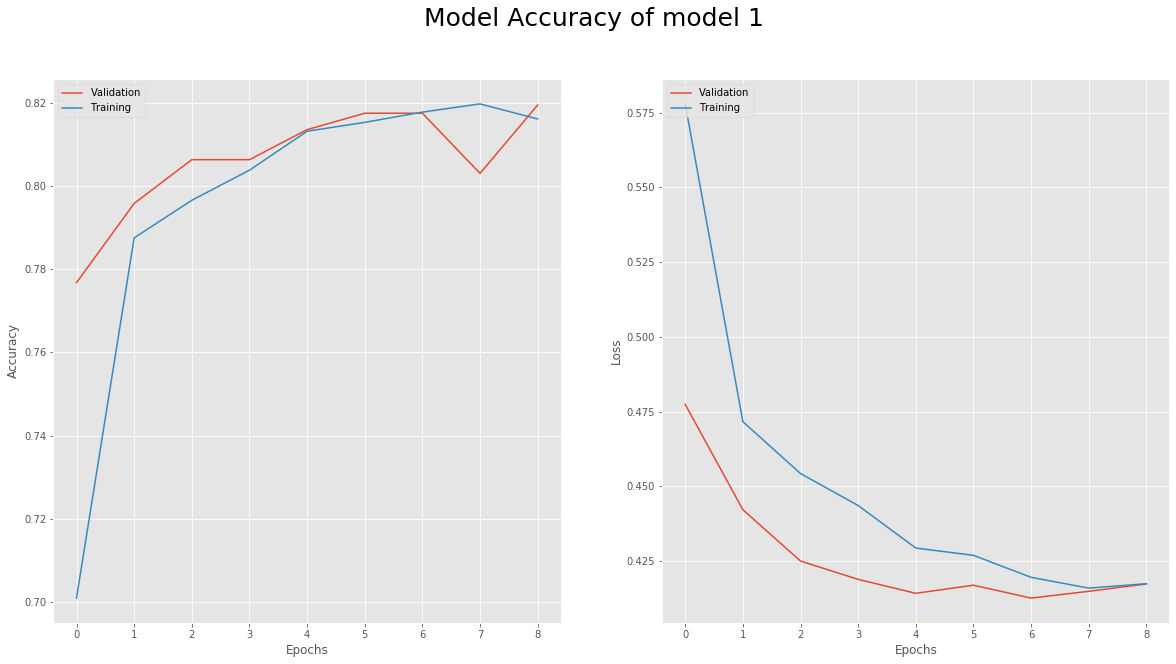

In [75]:
# learning curve
plot_lr_curves(history1, 1)

In [85]:
# create model 2
model2 = create_lstm_complex(spatial_dropout, dropout, learning_rate= learning_rate)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 300)      8796000     Text_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 33, 300)      0           embedding_1[6][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 256)          439296      spatial_dropout1d_7[0][0]        
____________________________________________________________________________________________

In [86]:
# fit model 2
history2 = model2.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 50, batch_size= 32, callbacks= [early_stopping])

Epoch 1/15
191/191 [==============================] - 21s 110ms/step - loss: 0.6262 - accuracy: 0.6394 - val_loss: 0.5089 - val_accuracy: 0.7702
Epoch 2/15
191/191 [==============================] - 22s 114ms/step - loss: 0.4922 - accuracy: 0.7813 - val_loss: 0.4574 - val_accuracy: 0.7905
Epoch 3/15
191/191 [==============================] - 22s 116ms/step - loss: 0.4691 - accuracy: 0.7897 - val_loss: 0.4325 - val_accuracy: 0.7997
Epoch 4/15
191/191 [==============================] - 22s 116ms/step - loss: 0.4480 - accuracy: 0.8018 - val_loss: 0.4249 - val_accuracy: 0.8056
Epoch 5/15
191/191 [==============================] - 22s 117ms/step - loss: 0.4357 - accuracy: 0.8084 - val_loss: 0.4216 - val_accuracy: 0.8109
Epoch 6/15
191/191 [==============================] - 22s 118ms/step - loss: 0.4270 - accuracy: 0.8115 - val_loss: 0.4220 - val_accuracy: 0.8096
Epoch 7/15
191/191 [==============================] - 22s 118ms/step - loss: 0.4213 - accuracy: 0.8172 - val_loss: 0.4237 - val_ac

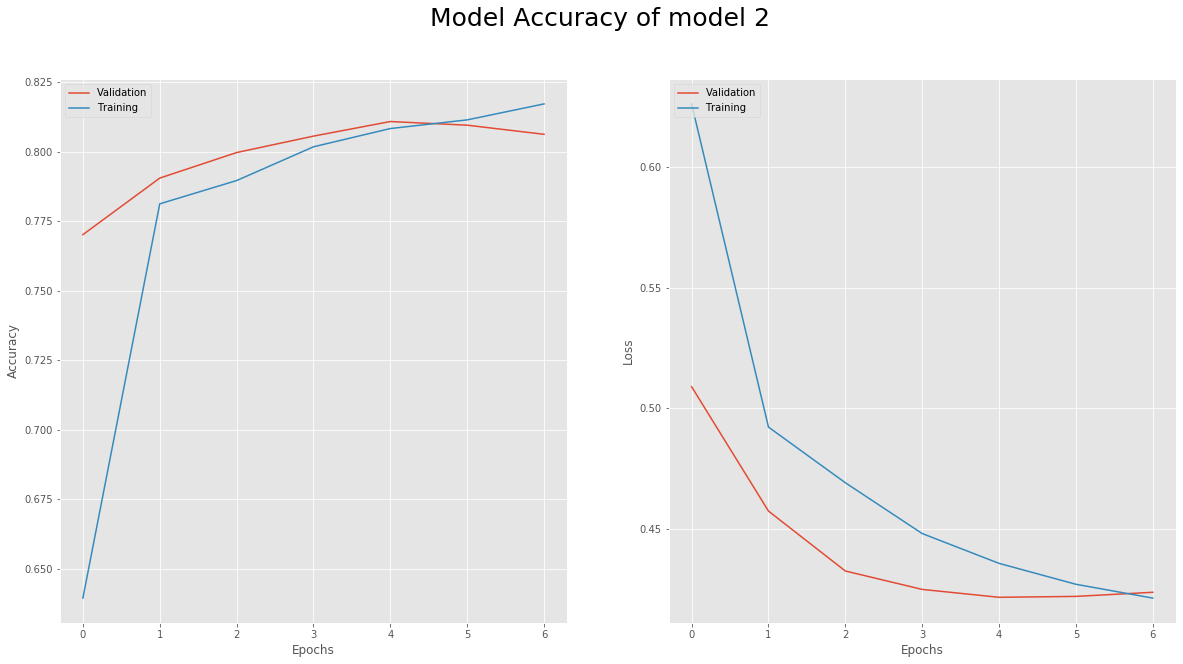

In [87]:
plot_lr_curves(history2, 2)

In [96]:
# create model 3 
model3 = create_lstm_gru(learning_rate= learning_rate)
model3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 300)      8796000     Text_input[0][0]                 
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 33, 300)      90300       embedding_1[11][0]               
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 33, 300)      0           Dense_1[0][0]                    
____________________________________________________________________________________________

In [97]:
# fit model 3
history3 = model3.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 100, batch_size= 32, callbacks= [early_stopping])

Epoch 1/100
191/191 [==============================] - 14s 71ms/step - loss: 0.6111 - accuracy: 0.6678 - val_loss: 0.5081 - val_accuracy: 0.7722
Epoch 2/100
191/191 [==============================] - 14s 73ms/step - loss: 0.4703 - accuracy: 0.7947 - val_loss: 0.4546 - val_accuracy: 0.7873
Epoch 3/100
191/191 [==============================] - 15s 81ms/step - loss: 0.4402 - accuracy: 0.8074 - val_loss: 0.4294 - val_accuracy: 0.8017
Epoch 4/100
191/191 [==============================] - 15s 80ms/step - loss: 0.4254 - accuracy: 0.8167 - val_loss: 0.4215 - val_accuracy: 0.8162
Epoch 5/100
191/191 [==============================] - 16s 82ms/step - loss: 0.4097 - accuracy: 0.8271 - val_loss: 0.4160 - val_accuracy: 0.8175
Epoch 6/100
191/191 [==============================] - 16s 81ms/step - loss: 0.4026 - accuracy: 0.8245 - val_loss: 0.4466 - val_accuracy: 0.7984
Epoch 7/100
191/191 [==============================] - 15s 78ms/step - loss: 0.3909 - accuracy: 0.8374 - val_loss: 0.4128 - val_ac

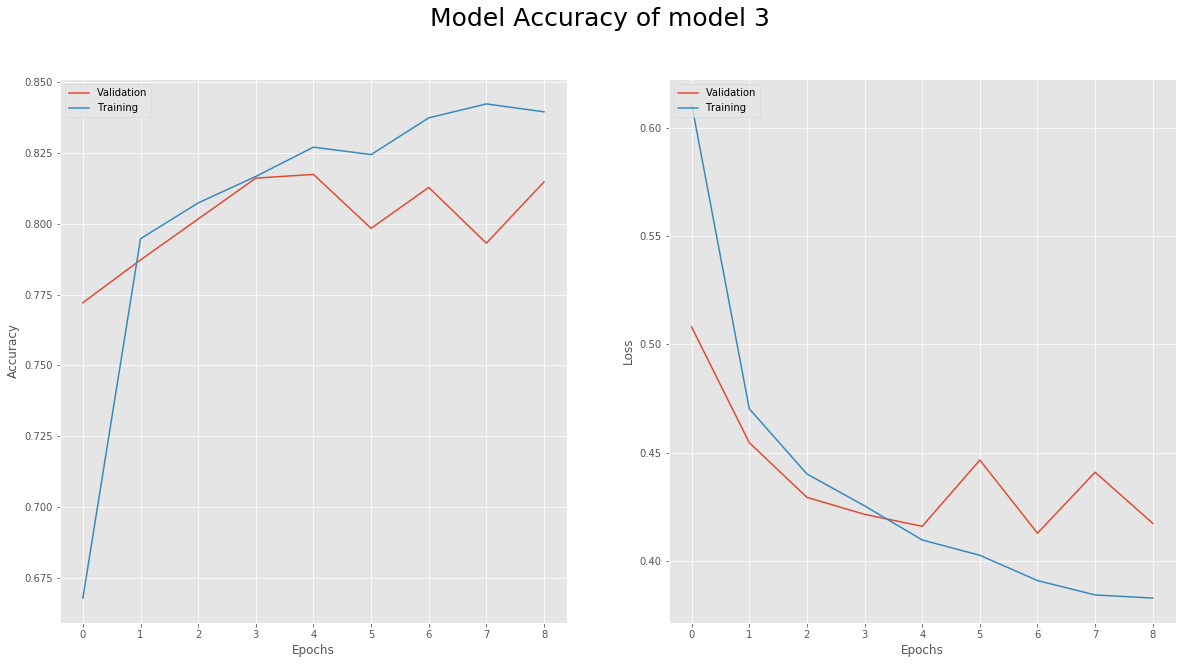

In [99]:
# learning curves
plot_lr_curves(history3, 3)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 300)      8796000     Text_input[0][0]                 
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 33, 300)      90300       embedding_1[12][0]               
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 33, 300)      0           Dense_1[0][0]                    
____________________________________________________________________________________________

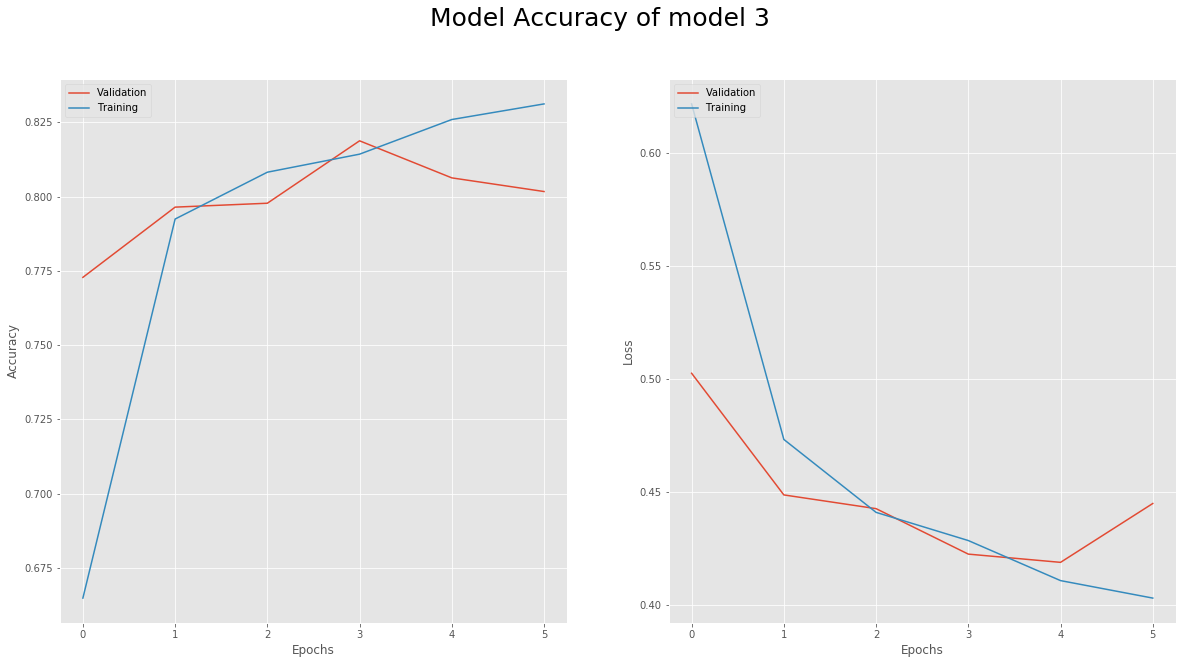

In [100]:
# Deal overfitting
early_stopping.patience= 1
model3 = create_lstm_gru(learning_rate= learning_rate)
model3.summary()
history3 = model3.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 100, batch_size= 32, callbacks= [early_stopping])
plot_lr_curves(history3, 3)

In [115]:
# create model 4
model4 = create_lstm_gru_conv(dropout= 0.1, learning_rate= learning_rate)
model4.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      8796000     Text_input[0][0]                 
__________________________________________________________________________________________________
Convolutional (Conv1D)          (None, 33, 64)       57664       embedding_2[4][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 16, 64)       0           Convolutional[0][0]              
___________________________________________________________________________________________

In [116]:
# fit model 4 
history4 = model4.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 100, batch_size= 32, callbacks= [early_stopping])

Epoch 1/100
191/191 [==============================] - 7s 38ms/step - loss: 0.5947 - accuracy: 0.6860 - val_loss: 0.4871 - val_accuracy: 0.7873
Epoch 2/100
191/191 [==============================] - 6s 34ms/step - loss: 0.4587 - accuracy: 0.7966 - val_loss: 0.4589 - val_accuracy: 0.7978
Epoch 3/100
191/191 [==============================] - 6s 34ms/step - loss: 0.4277 - accuracy: 0.8167 - val_loss: 0.4411 - val_accuracy: 0.7978
Epoch 4/100
191/191 [==============================] - 7s 36ms/step - loss: 0.4115 - accuracy: 0.8246 - val_loss: 0.4292 - val_accuracy: 0.8083
Epoch 5/100
191/191 [==============================] - 7s 37ms/step - loss: 0.3996 - accuracy: 0.8337 - val_loss: 0.4277 - val_accuracy: 0.8122
Epoch 6/100
191/191 [==============================] - 7s 37ms/step - loss: 0.3886 - accuracy: 0.8396 - val_loss: 0.4529 - val_accuracy: 0.7991


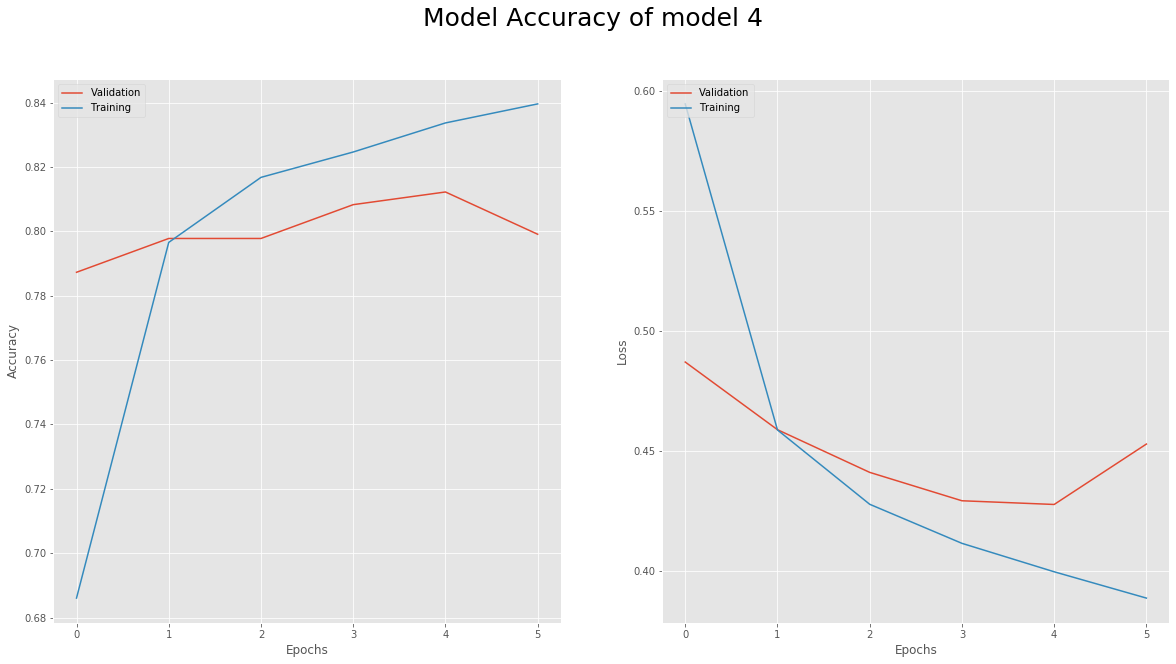

In [118]:
# plot learning curve
plot_lr_curves(history4, 4)

Epoch 1/2
191/191 [==============================] - 6s 34ms/step - loss: 0.5886 - accuracy: 0.6954 - val_loss: 0.4750 - val_accuracy: 0.7814
Epoch 2/2
191/191 [==============================] - 6s 32ms/step - loss: 0.4513 - accuracy: 0.8041 - val_loss: 0.4484 - val_accuracy: 0.7932


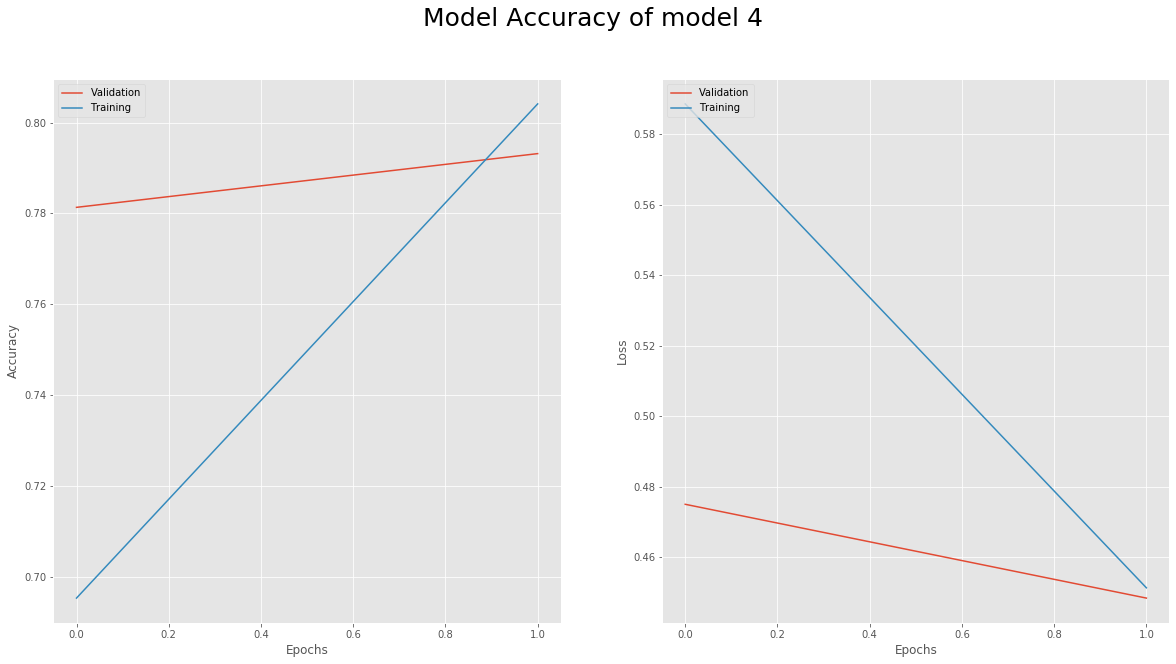

In [120]:
# Deal with overfitting
model4 = create_lstm_gru_conv(dropout= 0.1, learning_rate= learning_rate)
history4 = model4.fit([text_input_train, meta_input_train], y_train, validation_split= 0.2,\
                      epochs= 2, batch_size= 32)
plot_lr_curves(history4, 4)

In [ ]:
# submission
lstm_pred = model1.predict([text_input_test, meta_input_test])
lstm_complex_pred = model2.predict([text_input_test, meta_input_test])
lstm_gru_pred = model3.predict([text_input_test, meta_input_test])
lstm_gru_conv_pred = model4.predict([text_input_test, meta_input_test])

# Merge all predictions
final_pred = (lstm_pred + lstm_complex_pred + lstm_gru_pred + lstm_gru_conv_pred)/4

In [132]:
df_sub = pd.DataFrame({ 'id': total[len(df_train):]['id'],
                      })
df_sub['lstm_pred'] = lstm_pred
df_sub['lstm_complex_pred'] = lstm_complex_pred
df_sub['lstm_gru_pred'] = lstm_gru_pred
df_sub['lstm_gru_conv_pred'] = lstm_gru_conv_pred
df_sub['final_pred'] = final_pred

df_sub.head(10)

,id,lstm_pred,lstm_complex_pred,lstm_gru_pred,lstm_gru_conv_pred,final_pred
7613,0,0.895339,0.679410,0.670634,0.405717,0.662775
7614,2,0.737801,0.498991,0.804216,0.630424,0.667858
7615,3,0.881617,0.696234,0.966385,0.821108,0.841336
7616,9,0.761617,0.448222,0.292797,0.249359,0.437999
7617,11,0.989814,0.957027,0.986308,0.888568,0.955429
7618,12,0.621628,0.436442,0.282407,0.245263,0.396435
7619,21,0.080204,0.153626,0.235271,0.139044,0.152036
7620,22,0.065292,0.042419,0.096442,0.096765,0.075229
7621,27,0.078316,0.041872,0.094277,0.102890,0.079339
7622,29,0.084466,0.072336,0.128420,0.128089,0.103328


In [133]:
df_sub['merge_target'] = df_sub['final_pred'].apply(lambda x: 0 if x < 0.5 else 1)

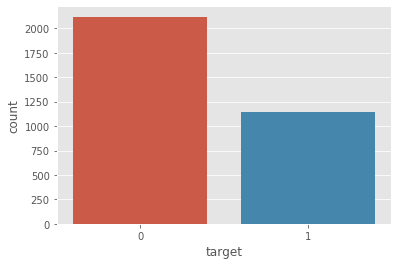

In [138]:
sns.countplot(df_sub['merge_target'])

In [140]:
df_sub[['id', 'merge_target']].rename.to_csv('merge_submission0.csv', index= False)

In [141]:
# submission with all models separately
df_sub['lstm_target'] = df_sub['lstm_pred'].apply(lambda x: 0 if x < 0.5 else 1)
df_sub[['id', 'lstm_target']].rename({'lstm_target':'target'}, axis= 1).\
to_csv('lstm_submission0.csv', index= False)

In [143]:
df_sub['lstm_complex_target'] = df_sub['lstm_complex_pred'].apply(lambda x: 0 if x < 0.5 else 1)
df_sub[['id', 'lstm_complex_target']].rename({'lstm_complex_target':'target'}, axis= 1).\
to_csv('lstm_complex_submission0.csv', index= False)

In [144]:
df_sub['lstm_gru_target'] = df_sub['lstm_gru_pred'].apply(lambda x: 0 if x < 0.5 else 1)
df_sub[['id', 'lstm_gru_target']].rename({'lstm_gru_target':'target'}, axis= 1).\
to_csv('lstm_gru_submission0.csv', index= False)

In [145]:
df_sub['lstm_gru_conv_target'] = df_sub['lstm_gru_conv_pred'].apply(lambda x: 0 if x < 0.5 else 1)
df_sub[['id', 'lstm_gru_conv_target']].rename({'lstm_gru_conv_target':'target'}, axis= 1).\
to_csv('lstm_gru_conv_submission0.csv', index= False)

In [ ]:
# all models performed approximately same
# merged model is so far the best one 